# Part 2 - Classification with PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Hyperparameters

In [2]:
device = 'cuda'
n_epochs = 10
batch_size_train = 128
batch_size_test = 32

# Prepare MNIST image dataset

Using torchvision api to download MNIST data

In [3]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_data = torchvision.datasets.MNIST('./data', train=True, download=True,
                                       transform=transform)
validation_data = torchvision.datasets.MNIST('./data', train=False, download=True,
                                      transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, 
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size_test, 
                                           shuffle=True)

# Define Model

In [4]:
# Create simple model with only 1 input, 1 hidden and 1 output layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 784 input node, 50 hidden output
        self.fc1 = nn.Linear(784, 50)
        # 50 input. Input must be same as output of layer before
        # 10 is the output of the model. Number of classes of data
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x)

In [5]:
# Initialize model and send to GPU
network = Net().to(device)

# Set algorithm for parameter update
optimizer = optim.Adam(network.parameters())

# Train Model

In [6]:
train_losses, train_counter, val_losses = [], [], []

In [7]:
# Almost the same format with training loop.
# But, without .backward(), .step()
# Also using different data loader.
def evaluate():
    network.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.shape[0], -1)
            output = network(data)
            val_loss += F.nll_loss(output, target, size_average=False).item() 
            
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    val_loss /= len(validation_loader.dataset)
    val_losses.append(val_loss)
    print('\nValidation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset),
        100. * correct / len(validation_loader.dataset)))

In [8]:
for epoch in range(1, n_epochs + 1):

    # Print training loss for every 10 batch
    log_interval = 10

    # Set model to training mode
    # Change behavior of some layers like batchnorm, dropout, etc
    network.train()

    for batch_idx, (data, target) in enumerate(train_loader):

        # Send tensor to specified device
        # Default on CPU
        # Sending them to GPU OR CUDA
        data, target = data.to(device), target.to(device)

        # Reset all gradient to zero after each iteration
        # To prevent gradient accumulation
        optimizer.zero_grad()

        # Change shape of input data to fit format of fully connected
        data = data.view(data.shape[0], -1)

        # Forward pass
        output = network(data)

        # Loss Calculation
        loss = F.nll_loss(output, target)

        # Calculate the update value for every parameters
        # Does not update parameter value
        loss.backward()

        # Update all parameters according to the gradient value
        optimizer.step()
        
        # Print training loss
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'model.pth')
            torch.save(optimizer.state_dict(), 'optimizer.pth')

    # Perform evaluation
    evaluate()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.289191
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.771662
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.310725
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.031247
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.792029
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.764422
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.710082
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.601530
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.468293
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.451503
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.452308
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.543170
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.366131
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.451164
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.505703
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.498328
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.353458
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.421349
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.420000
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.266039
Train Epoch: 1 [

# View Evaluation

In [9]:
# Evaluate on one batch only
examples = enumerate(validation_loader)
batch_idx, (example_data, example_targets) = next(examples)

# To run model without performing grading parameters
with torch.no_grad():

    # Prepare dataset
    pred_data = example_data
    pred_data = pred_data.view(pred_data.shape[0], -1)

    # Set model to evaluation mode
    network.eval()

    # Inference
    predictions = network(pred_data.to(device))

    # Format predictions to get labels
    predicted_labels = predictions.data.max(1, keepdim=True)[1].cpu().detach().numpy()

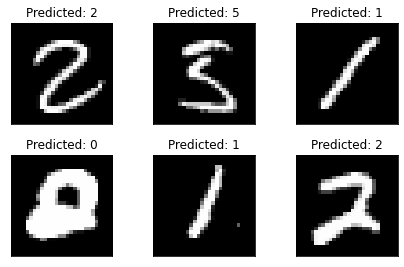

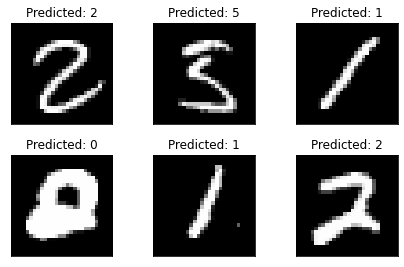

In [10]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Predicted: {}".format(predicted_labels[i][0]))
    plt.xticks([])
    plt.yticks([])
fig

### View model weights

In [11]:
for name, param in network.state_dict().items():
    print("Layer: ", name)
    print(param)
    print()

Layer:  fc1.weight
tensor([[-0.0138,  0.0075, -0.0176,  ...,  0.0324,  0.0077,  0.0231],
        [ 0.0142,  0.0178, -0.0237,  ..., -0.0002, -0.0345, -0.0274],
        [ 0.0040,  0.0414, -0.0250,  ..., -0.0097, -0.0222,  0.0004],
        ...,
        [ 0.0094,  0.0104, -0.0088,  ..., -0.0189, -0.0245, -0.0024],
        [ 0.0206, -0.0119,  0.0219,  ..., -0.0138,  0.0130,  0.0222],
        [-0.0374, -0.0221, -0.0391,  ..., -0.0501, -0.0511, -0.0493]],
       device='cuda:0')

Layer:  fc1.bias
tensor([ 0.0259,  0.0169, -0.0173, -0.0309, -0.0095,  0.0174,  0.0093, -0.0020,
         0.0130,  0.0164, -0.0158, -0.0210, -0.0151, -0.0215,  0.0080, -0.0213,
        -0.0643, -0.0202,  0.0010,  0.0047,  0.0318, -0.0434,  0.0276,  0.0175,
        -0.0147,  0.0181,  0.0165,  0.0054,  0.0373,  0.0248, -0.0207,  0.0378,
        -0.0289, -0.0132,  0.0185, -0.0084, -0.0006,  0.0228, -0.0218, -0.0065,
         0.0141, -0.0079, -0.0364,  0.0617,  0.0073,  0.0271,  0.0156, -0.0135,
         0.0109,  0.0204]